In [1]:
import sqlite3
import pandas as pd
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
import numpy as np

# Reading Data and Pre-processing

In [3]:
con=sqlite3.connect('database.sqlite')
print(pd.read_sql_query("""SELECT name from sqlite_master where type= 'table';""",con))
data=pd.read_sql_query("""SELECT * from Reviews""",con)
print(data.shape)
filtered_data=data[data.Score!=3]
print(filtered_data.shape)
filtered_data['Score']=filtered_data['Score'].replace(to_replace=(5,4),value='positive')
filtered_data['Score']=filtered_data['Score'].replace(to_replace=(1,2),value='negative')
print(filtered_data.head(5))
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
print(final.shape)
final=final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)
final_data = final.sample(n=5000)
print(final_data.shape)

      name
0  Reviews
(568454, 10)
(525814, 10)


/home/abc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/abc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/abc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

# Stopwords in English

In [5]:
stopwords=set(stopwords.words('english'))
print(len(stopwords))
stopwords.remove('not')
stopwords.remove('nor')
stopwords.remove('no')
stopwords.add('br')
print(len(stopwords))

179
177


# Text Pre-proccessing

In [6]:
#Reference: Applied AI Course IPython notebook
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 5000/5000 [00:01<00:00, 2976.50it/s]


In [7]:
print(len(preprocessed_reviews))

5000


# Bag of Words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
count_vector=CountVectorizer()
final_vectors=count_vector.fit_transform(preprocessed_reviews)
print(final_vectors.shape)
std=StandardScaler(with_mean=False)
std_data=std.fit_transform(final_vectors)
std_data=std_data.todense()
labels=final_data['Score']
p=[30,50,100,250,500,1000,2500,5000]
#print(final_vectors)

(5000, 14533)


In [9]:
plt.show()

(5000, 2)


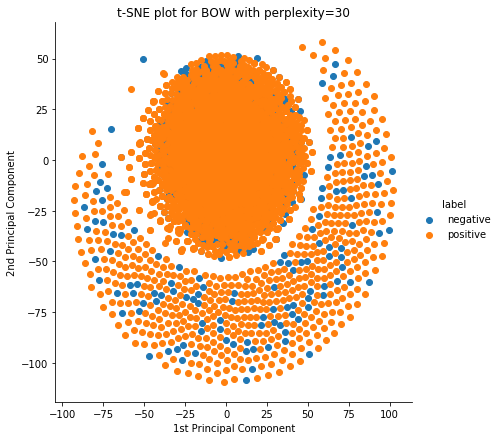

(5000, 2)


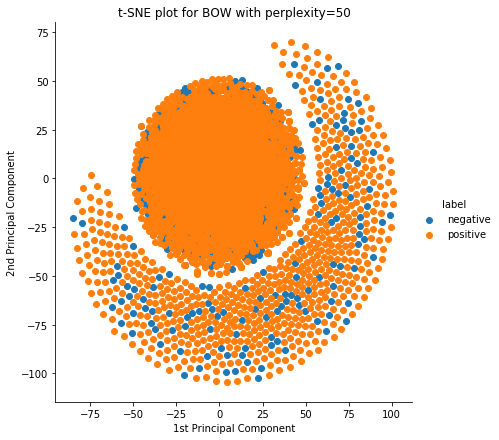

(5000, 2)


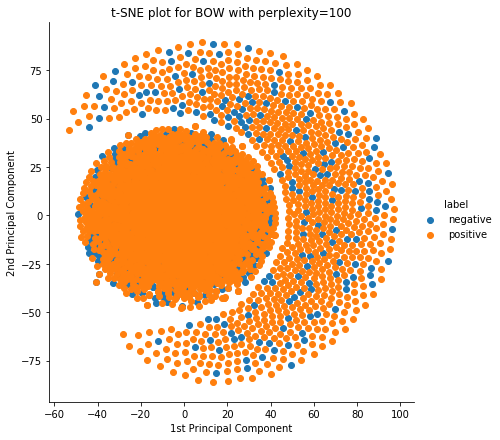

(5000, 2)


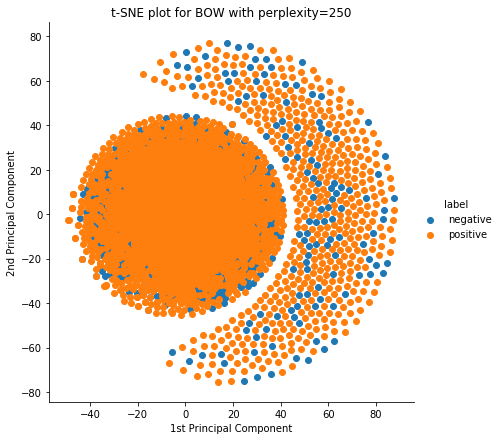

(5000, 2)


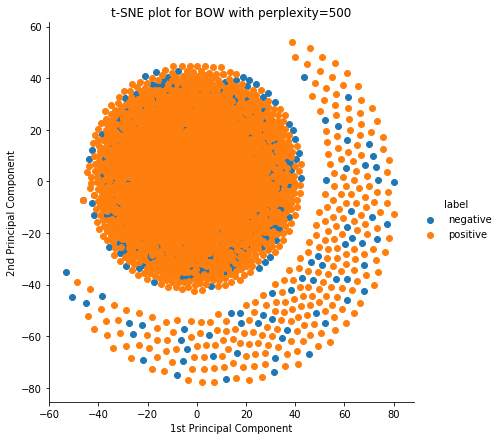

(5000, 2)


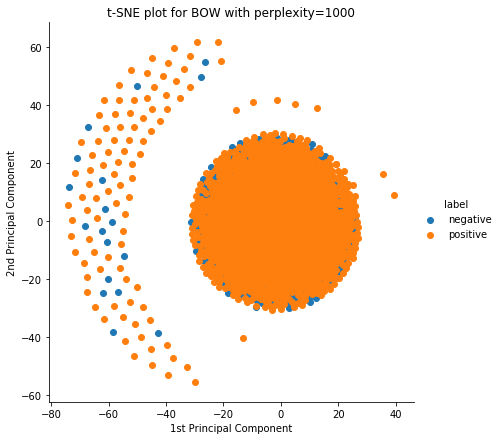

(5000, 2)


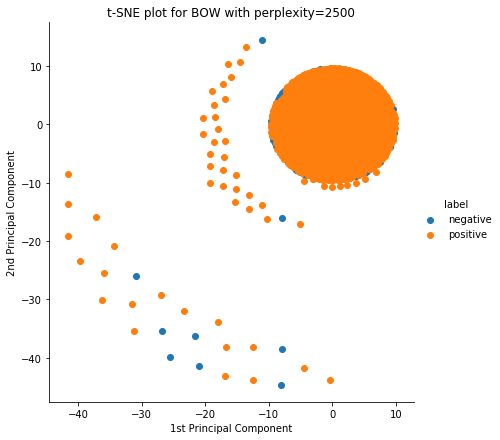

(5000, 2)


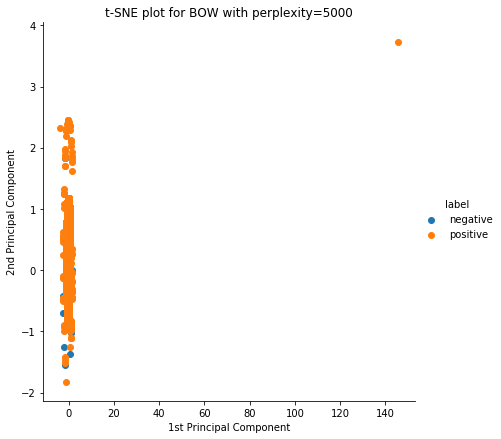

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
for pe in p:
    tsne=TSNE(n_components=2,perplexity=pe,learning_rate=200)
    tsne_data=tsne.fit_transform(std_data)
    print(tsne_data.shape)
    tsne_data=np.vstack((tsne_data.T,labels)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=("1st Principal Component","2nd Principal Component","label"))
    sns.FacetGrid(tsne_df,hue='label',height=6).map(plt.scatter,'1st Principal Component','2nd Principal Component').add_legend()
    plt.title("t-SNE plot for BOW with perplexity="+str(pe))
    plt.show()
    plt.close()

# Uni-gram,Bi-grams and Tri-grams

(5000, 330452)
(5000, 2)


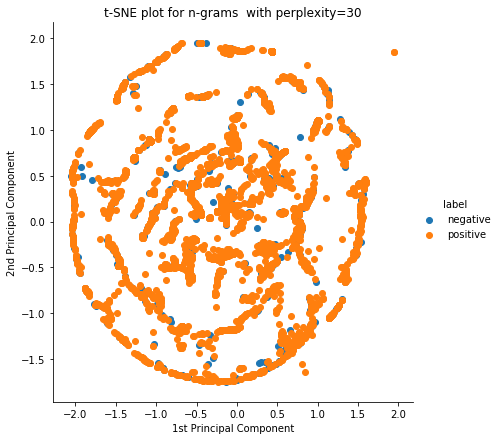

(5000, 2)


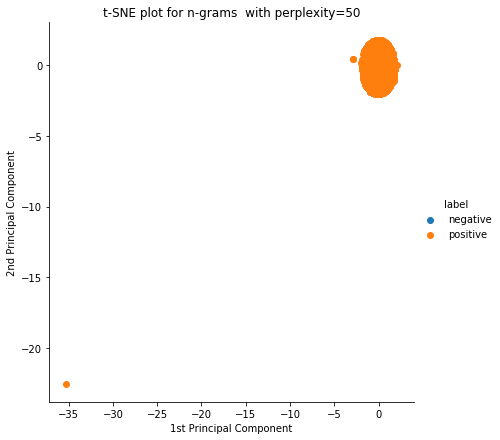

(5000, 2)


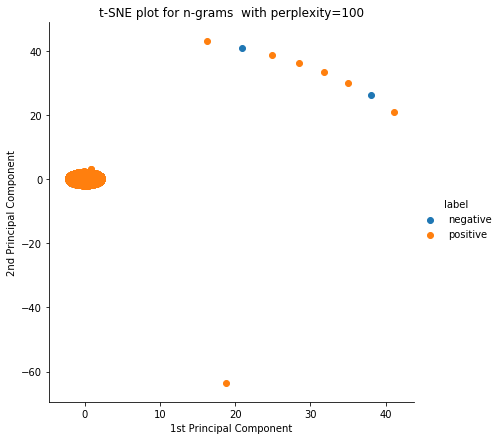

(5000, 2)


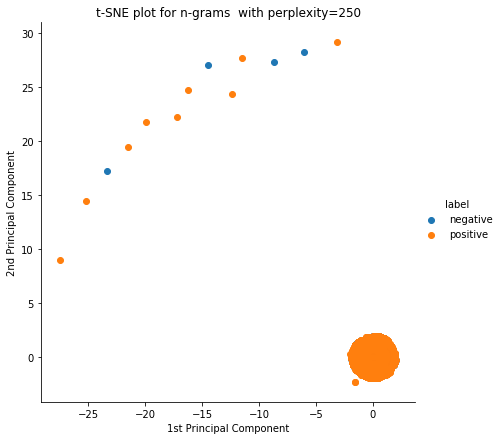

(5000, 2)


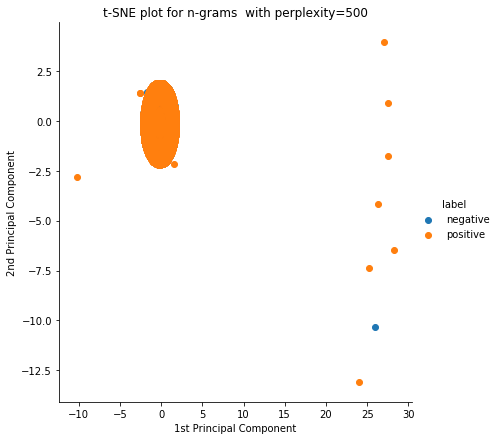

(5000, 2)


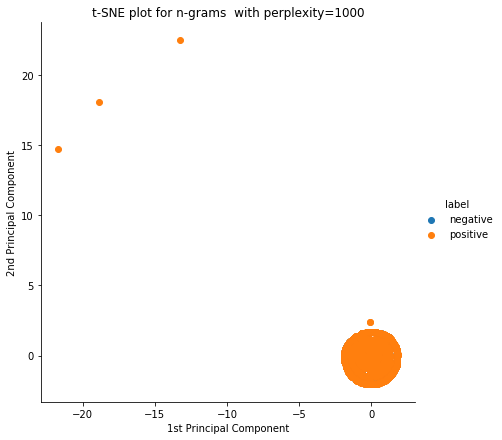

(5000, 2)


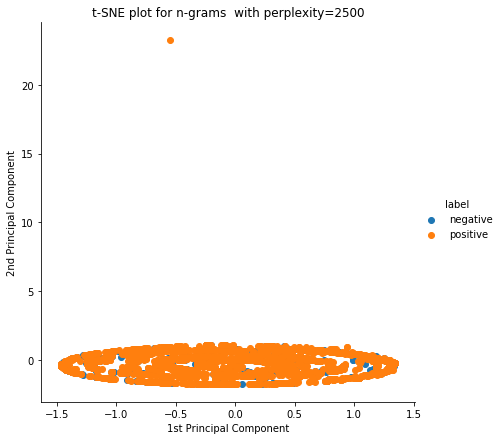

(5000, 2)


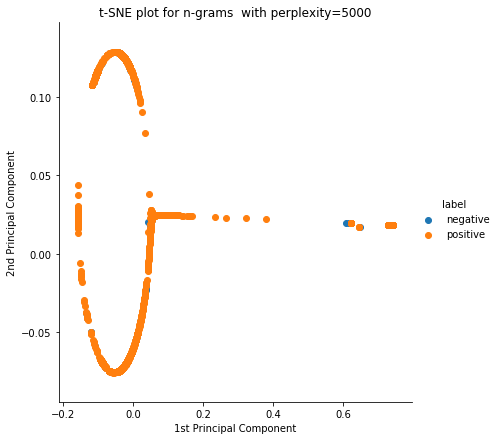

In [11]:
count_vector=CountVectorizer(ngram_range=(1,3))
final_vectors=count_vector.fit_transform(preprocessed_reviews)
print(final_vectors.shape)
std=StandardScaler(with_mean=False)
std_data=std.fit_transform(final_vectors)
std_data=std_data.todense()
for pe in p:
    tsne=TSNE(n_components=2,perplexity=pe,learning_rate=200)
    tsne_data=tsne.fit_transform(std_data)
    print(tsne_data.shape)
    tsne_data=np.vstack((tsne_data.T,labels)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=("1st Principal Component","2nd Principal Component","label"))
    sns.FacetGrid(tsne_df,hue='label',height=6).map(plt.scatter,'1st Principal Component','2nd Principal Component').add_legend()
    plt.title("t-SNE plot for n-grams  with perplexity="+str(pe))
    plt.show()
    plt.close()

# TF-IDF

(5000, 2)


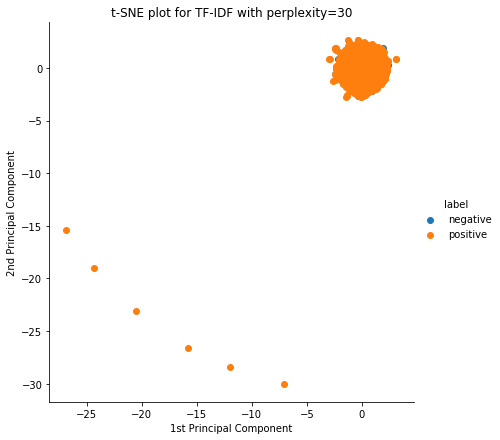

(5000, 2)


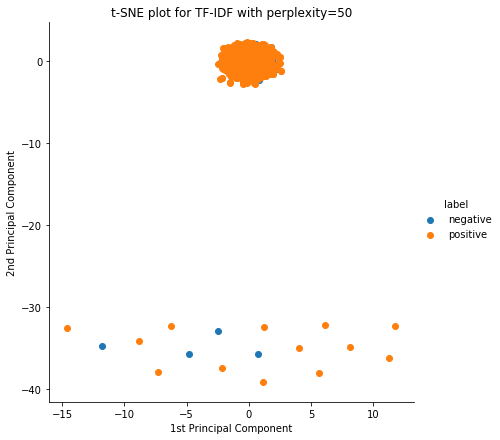

(5000, 2)


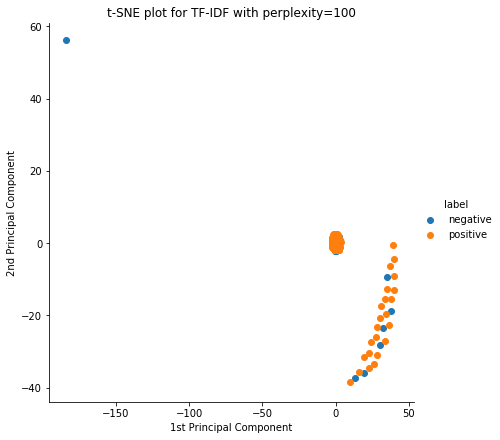

(5000, 2)


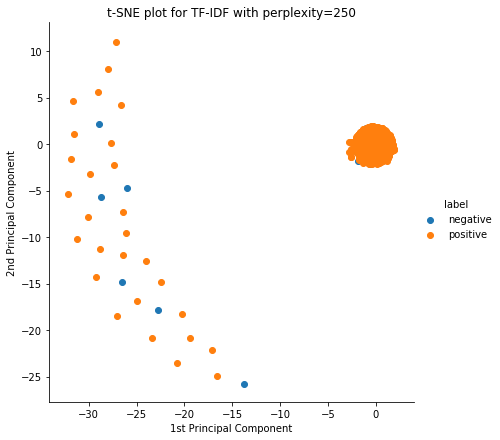

(5000, 2)


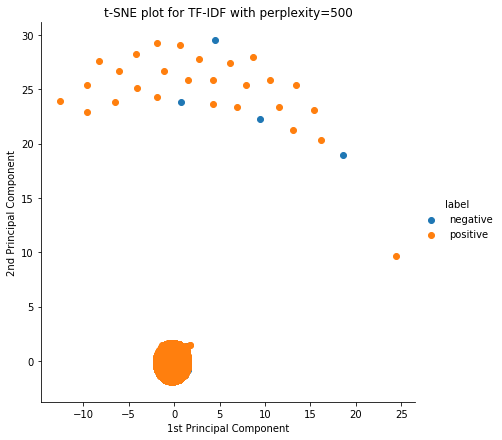

(5000, 2)


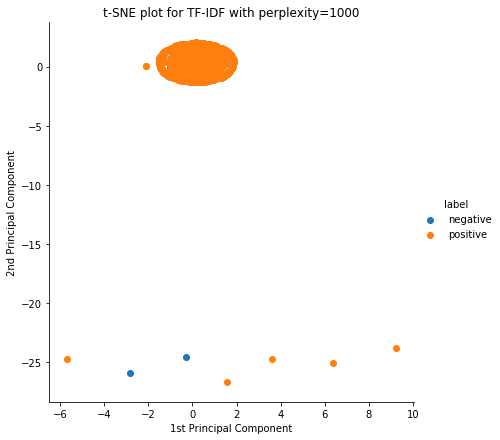

(5000, 2)


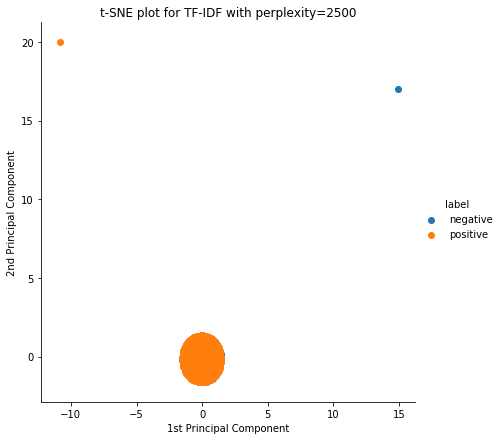

(5000, 2)


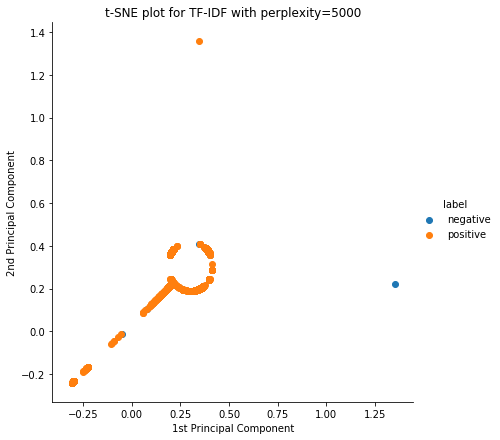

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector=TfidfVectorizer()
final_tfidf_vectors=tfidf_vector.fit_transform(preprocessed_reviews)
std=StandardScaler(with_mean=False)
std_data=std.fit_transform(final_tfidf_vectors)
std_data=std_data.todense()
for pe in p:
    tsne=TSNE(n_components=2,perplexity=pe,learning_rate=200)
    tsne_data=tsne.fit_transform(std_data)
    print(tsne_data.shape)
    tsne_data=np.vstack((tsne_data.T,labels)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=("1st Principal Component","2nd Principal Component","label"))
    sns.FacetGrid(tsne_df,hue='label',height=6).map(plt.scatter,'1st Principal Component','2nd Principal Component').add_legend()
    plt.title("t-SNE plot for TF-IDF with perplexity="+str(pe))
    plt.show()
    plt.close()
#print(final_tfidf_vectors)

# Average Word2Vec

In [13]:
import gensim
v=[]
for item in preprocessed_reviews:
    v.append(item.split(' '))
w2v_model=gensim.models.Word2Vec(v,min_count=5,size=100,workers=2)


100%|██████████| 5000/5000 [00:04<00:00, 1087.39it/s]


5000
100
(5000, 2)


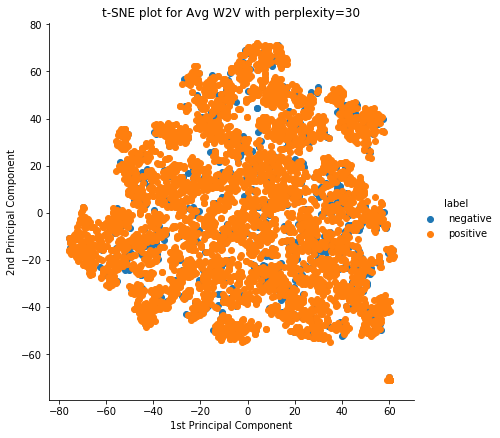

(5000, 2)


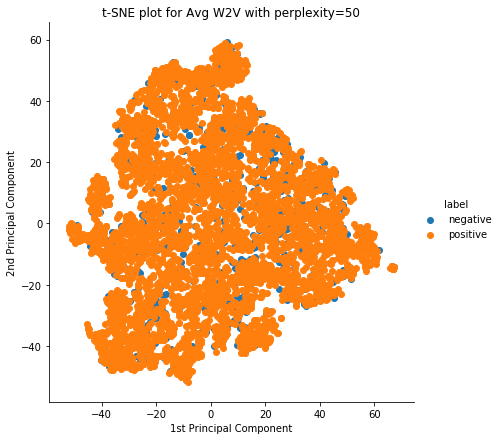

(5000, 2)


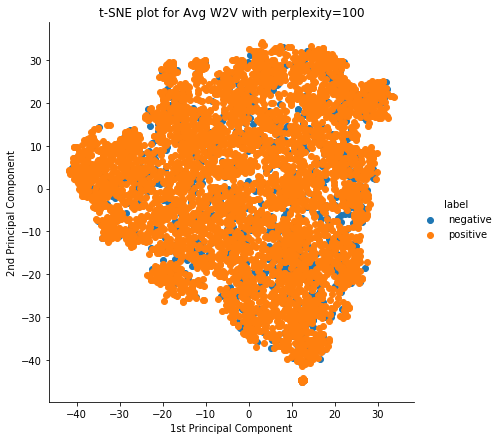

(5000, 2)


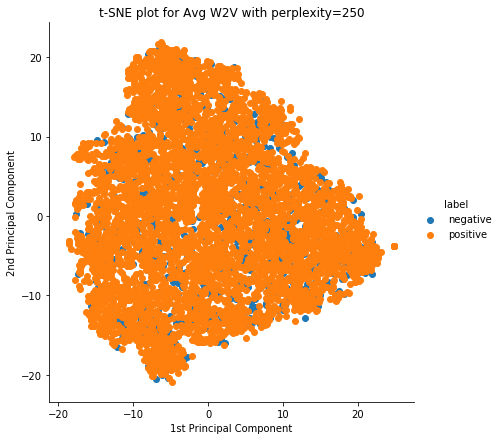

(5000, 2)


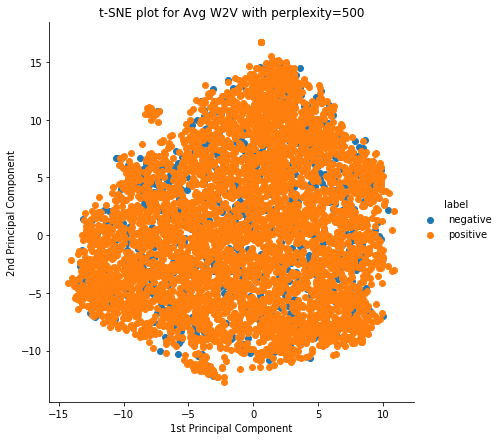

(5000, 2)


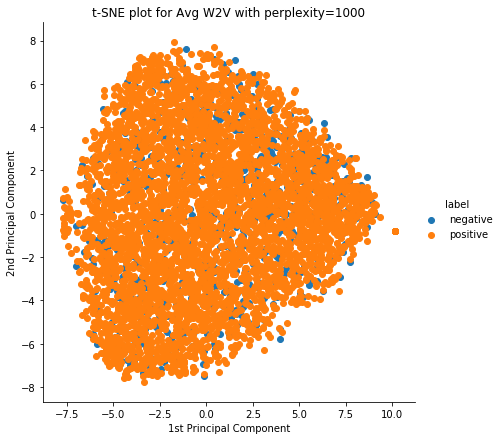

(5000, 2)


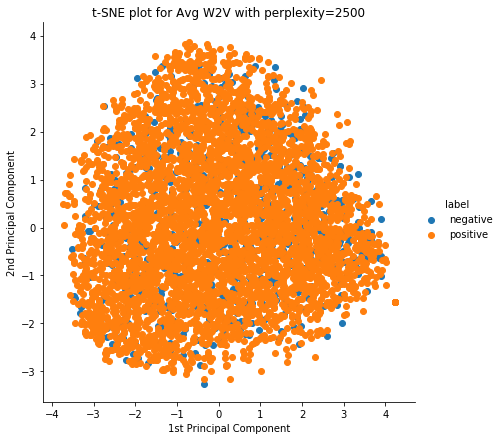

(5000, 2)


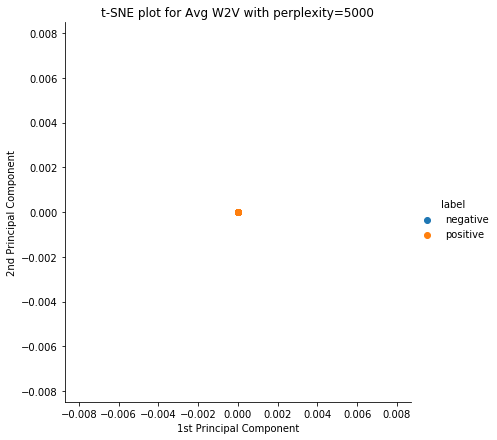

In [20]:
#Reference: Applied AI course
import numpy as np
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(v): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
std_data=std.fit_transform(sent_vectors)
for pe in p:
    tsne=TSNE(n_components=2,perplexity=pe,learning_rate=200)
    tsne_data=tsne.fit_transform(std_data)
    print(tsne_data.shape)
    tsne_data=np.vstack((tsne_data.T,labels)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=("1st Principal Component","2nd Principal Component","label"))
    sns.FacetGrid(tsne_df,hue='label',height=6).map(plt.scatter,'1st Principal Component','2nd Principal Component').add_legend()
    plt.title("t-SNE plot for Avg W2V with perplexity="+str(pe))
    plt.show()
    plt.close()

# Using Google's Word2Vec model

/home/abc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until

  0%|          | 0/5000 [00:00<?, ?it/s]/home/abc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.

100%|██████████| 5000/5000 [06:44<00:00, 12.37it/s]

5000
300
(5000, 2)


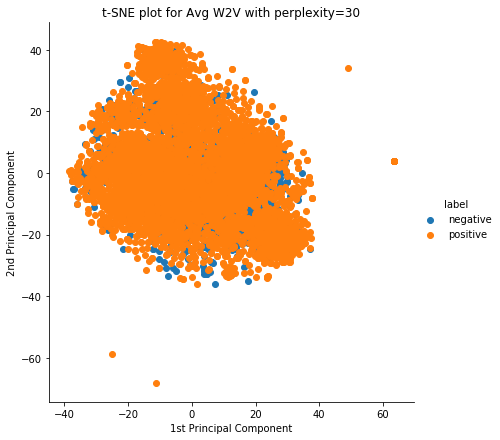

(5000, 2)


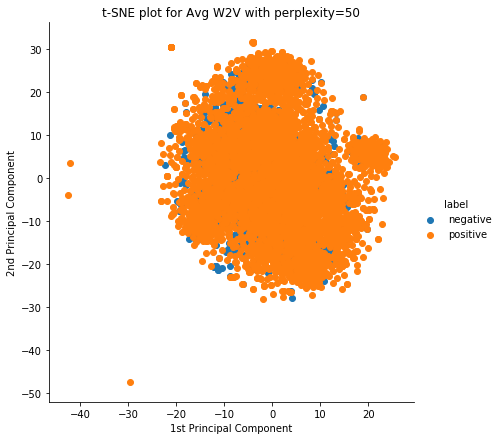

(5000, 2)


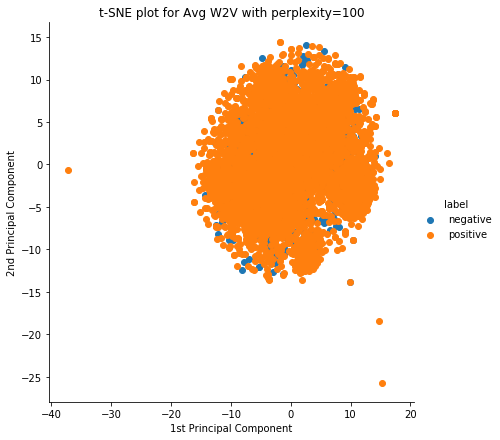

(5000, 2)


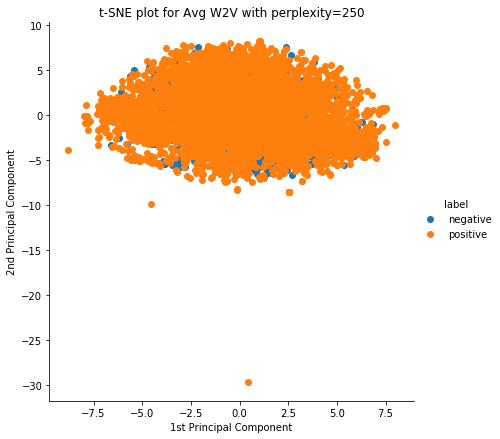

(5000, 2)


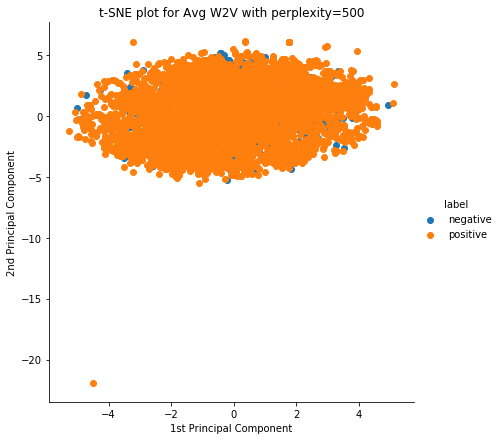

(5000, 2)


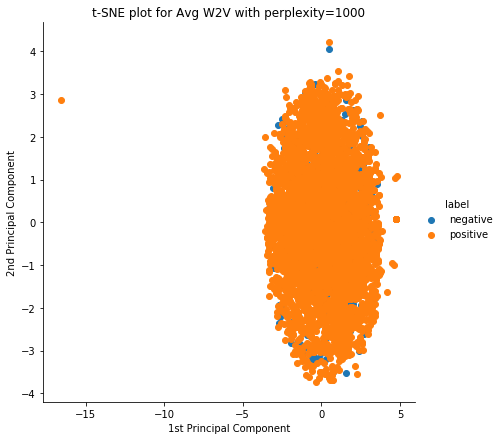

(5000, 2)


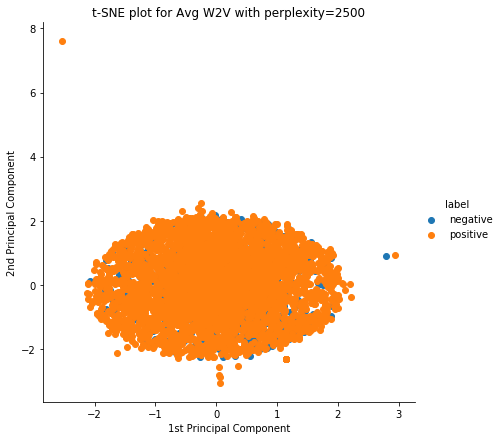

(5000, 2)


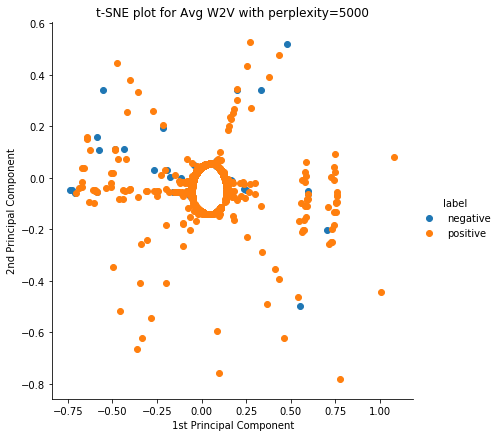

In [23]:
from gensim.models import KeyedVectors
w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(v): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
std_data=std.fit_transform(sent_vectors)
for pe in p:
    tsne=TSNE(n_components=2,perplexity=pe,learning_rate=200)
    tsne_data=tsne.fit_transform(std_data)
    print(tsne_data.shape)
    tsne_data=np.vstack((tsne_data.T,labels)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=("1st Principal Component","2nd Principal Component","label"))
    sns.FacetGrid(tsne_df,hue='label',height=6).map(plt.scatter,'1st Principal Component','2nd Principal Component').add_legend()
    plt.title("t-SNE plot for Avg W2V with perplexity="+str(pe))
    plt.show()
    plt.close()

# TF-IDF Weighted Word2Vec

In [28]:
# Reference Applied AI course ipyhton notebook
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
for sent in tqdm(v): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


/home/abc/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL



  0%|          | 0/5000 [00:00<?, ?it/s]/home/abc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



  0%|          | 1/5000 [00:00<09:20,  8.91it/s]


  0%|          | 2/5000 [00:00<09:20,  8.91it/s]


  0%|          | 3/5000 [00:00<13:50,  6.02it/s]


  0%|          | 4/5000 [00:00<14:24,  5.78it/s]


  0%|          | 6/5000 [00:00<11:30,  7.23it/s]


  0%|          | 10/5000 [00:00<08:43,  9.53it/s]


  0%|          | 13/5000 [00:01<07:30, 11.07it/s]


  0%|          | 16/5000 [00:01<09:12,  9.02it/s]


  0%| 

(5000, 2)


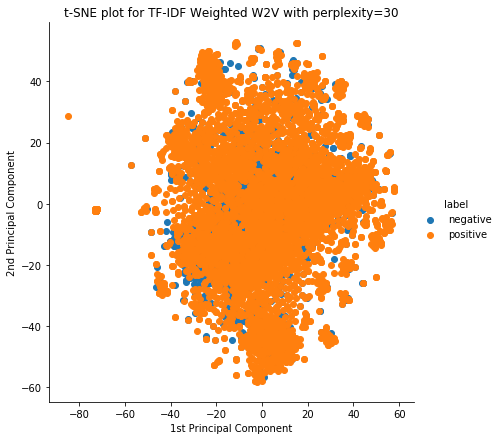

(5000, 2)


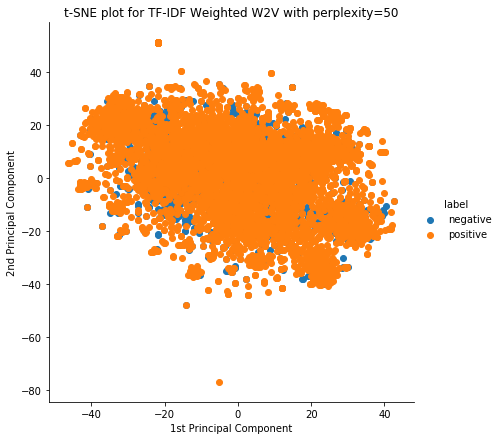

(5000, 2)


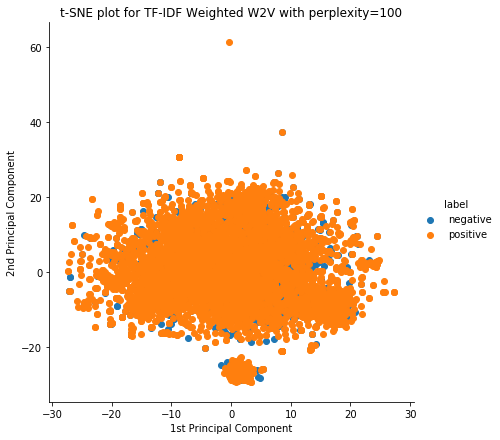

(5000, 2)


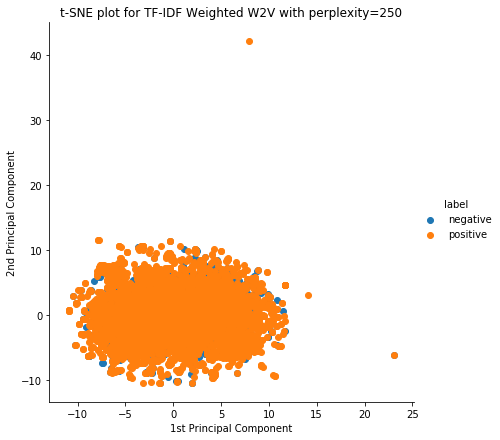

(5000, 2)


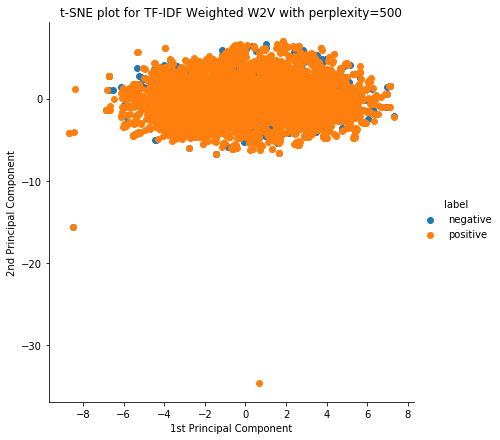

(5000, 2)


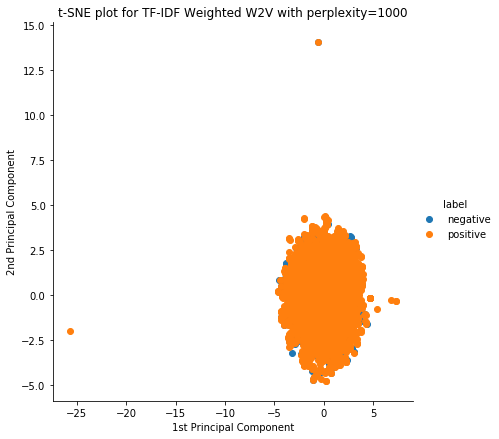

(5000, 2)


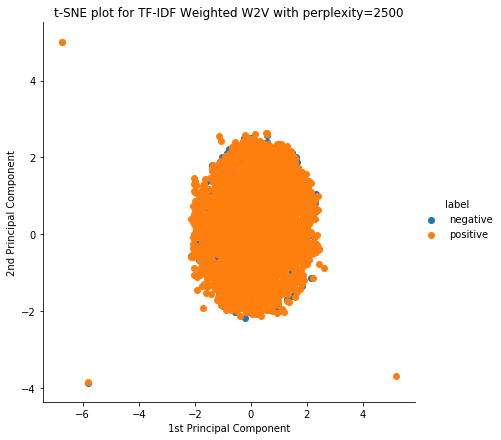

(5000, 2)


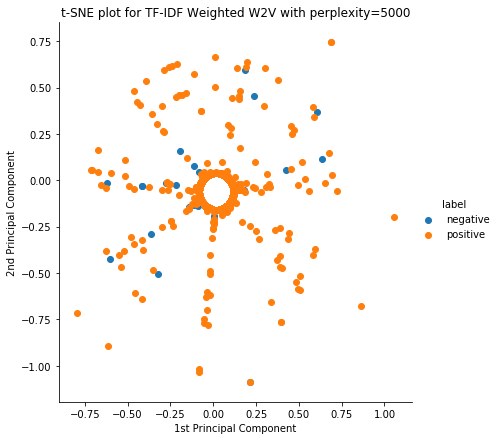

In [30]:
std_data=std.fit_transform(tfidf_sent_vectors)
for pe in p:
    tsne=TSNE(n_components=2,perplexity=pe,learning_rate=200)
    tsne_data=tsne.fit_transform(std_data)
    print(tsne_data.shape)
    tsne_data=np.vstack((tsne_data.T,labels)).T
    tsne_df=pd.DataFrame(data=tsne_data,columns=("1st Principal Component","2nd Principal Component","label"))
    sns.FacetGrid(tsne_df,hue='label',height=6).map(plt.scatter,'1st Principal Component','2nd Principal Component').add_legend()
    plt.title("t-SNE plot for TF-IDF Weighted W2V with perplexity="+str(pe))
    plt.show()
    plt.close()

# Conclusion

1. t-SNE plot for Amazon fine food reviews dataset is done on this work.
2. Amazon fine food reviews are transformed to numerical features before applying t-SNE algorithm.
3. Different algorithms i.e Bag of words, ngrams, TF-IDF and Word2Vec are applied to transform the text data to numerical feature.
3. t-SNE algorithm is applied with different perplexity values of 30,50,100,250,500,1000.2500,5000.
4. In all the t-SNE plots the negative and positive class data points are overlapping which shows that just by looking at the visual representation of data in 2Dimension we can not separate the two classes.